In [4]:
import IPython.display as disp
import pandas as pd
import numpy as np
import ggplot as gp
import scipy.stats as st
import statsmodels.api as sm
import math
import geopy.distance as gdist

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Analyzing the NYC Subway Dataset

## Section 0. References
Mann-Whitney U
* https://storage.googleapis.com/supplemental_media/udacityu/ud359-nd/Mann-Whitney%20U%20Test.pdf
* https://statistics.laerd.com/premium-sample/mwut/mann-whitney-test-in-spss-2.php

Two-tailed vs One-tailed
* http://www.ats.ucla.edu/stat/mult_pkg/faq/general/tail_tests.htm

## Section 1. Statistical Test

### 1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

The Mann-Whitney U-Test was used to analyze the NYC subway data. A two-tail P value was used because due to the uncertainty of whether rain increases or decreases the number of people using the subway. The Null Hypothesis used to compare between the two populations, rainy days and non rainy days is as follows:

$H_0$: The distribution of hourly entries are the same for the two populations.  
$H_A$: The distribution of hourly entries are different for the two populations.

Justification for this hypothesis will be explained in the next question. A two tailed p-critical value of .05 will be used.

### 1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

In order to choose an appropriate statistical test for the dataset, the shape of the distributions needed to be graphically shown:

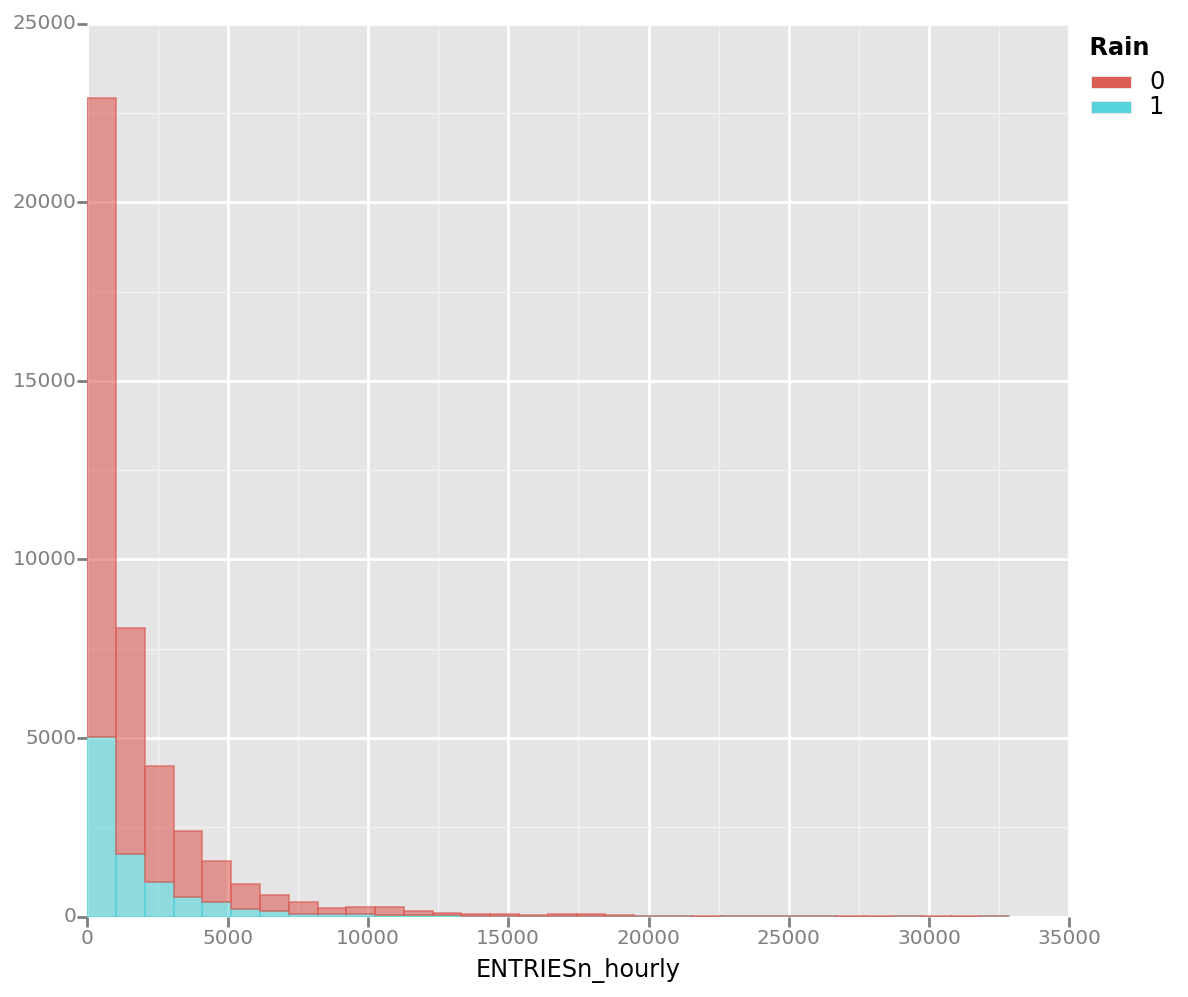

<ggplot: (281372577)>

In [8]:
df = pd.read_csv("./turnstile_weather_v2.csv")

df_rain = df[df['rain'] == 1]
df_no_rain = df[df['rain'] == 0]

df_rain_entries = df_rain.ENTRIESn_hourly
df_no_rain_entries = df_no_rain.ENTRIESn_hourly

gp.ggplot(gp.aes(x="ENTRIESn_hourly", fill='rain',color='rain'), data=df) +\
    gp.geom_histogram(alpha=0.6, binwidth=1000)

By looking at the histogram we see that the datasets seem to not follow a normal distribution. We can verify this statistically with the Shapiro Wilk's Test.

In [439]:
print(st.shapiro(df_rain_entries))
print(st.shapiro(df_no_rain_entries))

(0.5938820838928223, 0.0)
(0.5956180691719055, 0.0)


We can make a safe assumption that the populations are not normal after analyzing it visually and statistically.

In 1.1, the hypotheses are comparing the distributions of the two populations because we are making an assumption that the distributions are similarily shaped, as shown in the histogram above.

### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [440]:
with_rain_mean = round(df_rain_entries.mean(),2)
without_rain_mean = round(df_no_rain_entries.mean(),2)

U,p = st.mannwhitneyu(df_rain_entries, df_no_rain_entries)
p = round(p*2,7)

Mean Hourly Entries while raining: {{with_rain_mean}}  
Mean Hourly Entries while not raining: {{without_rain_mean}}  
U Statistic: {{U}}  
p-value: {{p}}

### 1.4 What is the significance and interpretation of these results?
Since our p-value of {{p}} is less than 0.05, we can reject the Null Hypothesis saying that the the two distributions are identical. We can conclude that rain does in fact play a factor for hourly entries in the NYC subway. Since the mean hourly entries while raining is greater than the mean hourly entries while not raining, we can also say that rain does in fact increase NYC Subway ridership.

## Section 2. Linear Regression

In [441]:
def linear_regression(features, values):
    features = sm.add_constant(features)
    model = sm.OLS(values, features)   
    return model.fit()

def predictions(dataframe):
    features = dataframe[['tempi', 'precipi', 'meanprecipi', 'pressurei',
                          'meanpressurei', 'wspdi', 'meanwspdi']]
    dummy_units = pd.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    dummy_units = pd.get_dummies(dataframe['conds'], prefix='cond')
    features = features.join(dummy_units)
    dummy_units = pd.get_dummies(dataframe['hour'], prefix='hour')
    features = features.join(dummy_units)
    dummy_units = pd.get_dummies(dataframe['day_week'], prefix='day')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe['ENTRIESn_hourly']

    # Perform linear regression
    results = linear_regression(features, values)
    intercept, params = results.params[0], results.params[1:]
    
    predictions = intercept + np.dot(features, params)
    return results, predictions

In [442]:
results, predictions = predictions(df)

### 2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
OLS using Statsmodels.

### 2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

Input Variables:  
* temperature
* precipitation
* mean precipitation
* mean temperature
* pressure
* mean pressure
* wind speed
* mean wind spead

Dummy Variables:  
* Unit
* Weather Conditions
* Hour of day
* Day of Week

### 2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model.

Features were selected in the beginning solely by intuition. For any features with categorical values, dummy values were used.

By investigating the values in the weather conditions column, I found that the indicators for fog, rain were not necessary since the weather condition column already captured that in one of the categories.

The hours feature was later converted into a categorical input since I suspected that a coefficient could not capture its effect on the the fluctuations in the number of hourly entries.

It was the same suspicion for adding the day_week feature as a dummy variable too, rendering the weekday indicator obsolete.


### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

In [443]:
results.params["tempi":"meanwspdi"]

tempi             -20.553456
precipi         -5278.170949
meanprecipi      2340.126654
pressurei       -2328.312263
meanpressurei    2115.454499
wspdi               6.728784
meanwspdi         -11.866581
dtype: float64

Conditions non-dummy variable:

In [444]:
results.params["cond_Clear":"day_6"]

cond_Clear                414.142969
cond_Fog                 1220.125423
cond_Haze                 568.133419
cond_Heavy Rain           768.350475
cond_Light Drizzle        -94.847605
cond_Light Rain           383.659695
cond_Mist                2047.822940
cond_Mostly Cloudy         69.639837
cond_Overcast             217.237075
cond_Partly Cloudy        349.692286
cond_Rain                 728.148948
cond_Scattered Clouds     355.865885
hour_0                    740.218417
hour_4                   -407.156527
hour_8                    -21.409212
hour_12                  2481.457969
hour_16                  1681.203241
hour_20                  2553.657459
day_0                    1013.501757
day_1                    1362.330927
day_2                    1372.008308
day_3                    1371.095055
day_4                    1323.526494
day_5                     472.926792
day_6                     112.582013
dtype: float64

### 2.5 What is your model’s $R^2$ (coefficients of determination) value?

In [445]:
r_squared = round(results.rsquared,4)
r_squared_pct = r_squared * 100
r_squared

0.5486

### 2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

Our $r^2$ value tells us that {{r_squared_pct}}% of the variation of hourly entries for the NYC subway is explained by the features provided. It indicates that there is a relationship between the features listed above and NYC ridership.

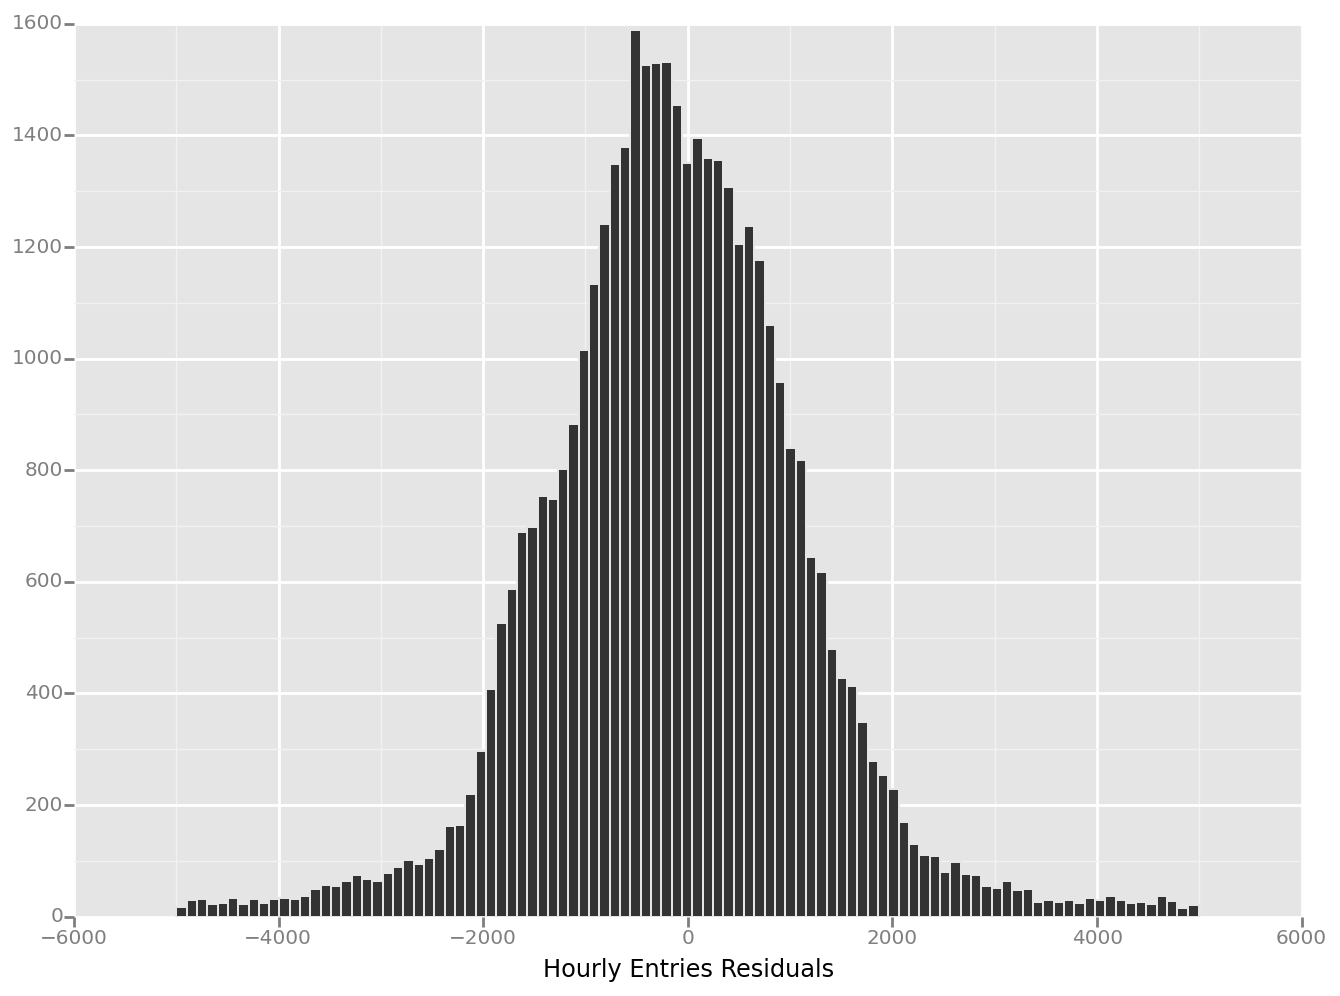

<ggplot: (350391517)>


In [446]:
def plot_residuals(turnstile_weather, predictions):
    turnstile_weather["Hourly Entries Residuals"] = turnstile_weather["ENTRIESn_hourly"] - predictions
    cropped = turnstile_weather[(turnstile_weather["Hourly Entries Residuals"] > -5000) & (turnstile_weather["Hourly Entries Residuals"] < 5000)]
    plt = gp.ggplot(gp.aes(x="Hourly Entries Residuals"), data=cropped) + gp.geom_histogram(binwidth=100)
    return plt

print(plot_residuals(df, predictions))
entries_mean = round(df['ENTRIESn_hourly'].mean(),2)

We can take a look at what the $r^2$ value represents by looking at the residuals. Majority of the residuals lie between -2000 to 2000, which is not good considering the mean is {{entries_mean}} for subway ridership. Therefore I think that this linear model is not enough to predict subway ridership.

## Section 3. Visualization
Please include two visualizations that show the relationships between two or more variables in the NYC subway data. Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
* You can combine the two histograms in a single plot or you can use two separate plots.
* If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
* For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
* Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

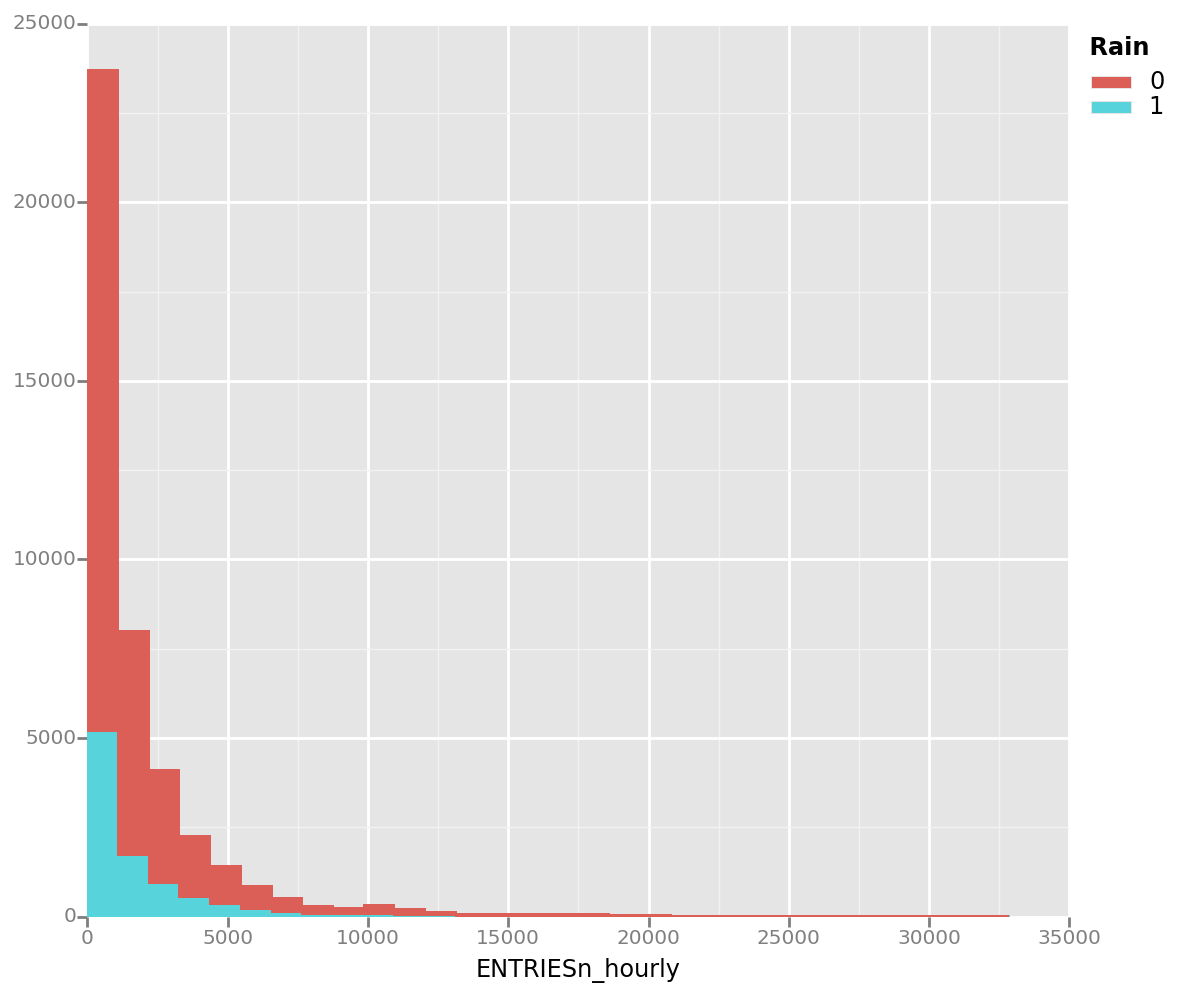

<ggplot: (351171013)>

In [447]:
gp.ggplot(df, gp.aes(x="ENTRIESn_hourly", fill="rain", color="rain")) + gp.geom_histogram()

### 3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
* Ridership by time-of-day
* Ridership by day-of-week

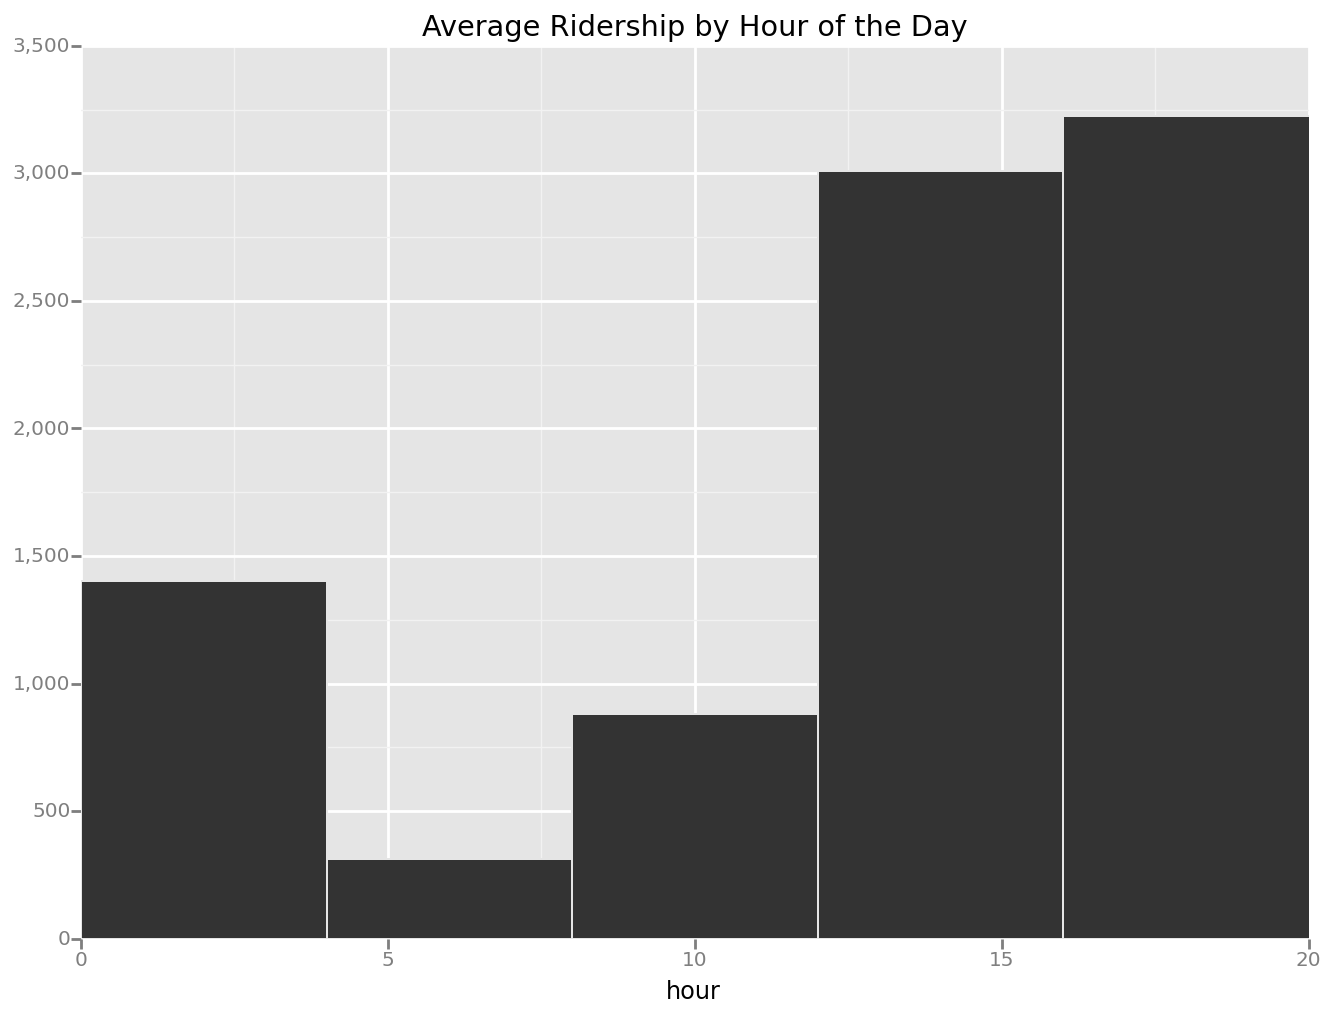

<ggplot: (314413541)>

In [448]:
grouped = df[["hour","ENTRIESn_hourly"]].groupby("hour")
ridership_hour = grouped.aggregate(np.mean)
ridership_hour = ridership_hour.reset_index()
gp.ggplot(ridership_hour, gp.aes('hour', weight="ENTRIESn_hourly")) + \
    gp.geom_bar(binwidth=4) + \
    gp.scale_y_continuous(labels='comma') + \
    gp.scale_x_continuous(limits=(0,20)) + \
    gp.ggtitle('Average Ridership by Hour of the Day')

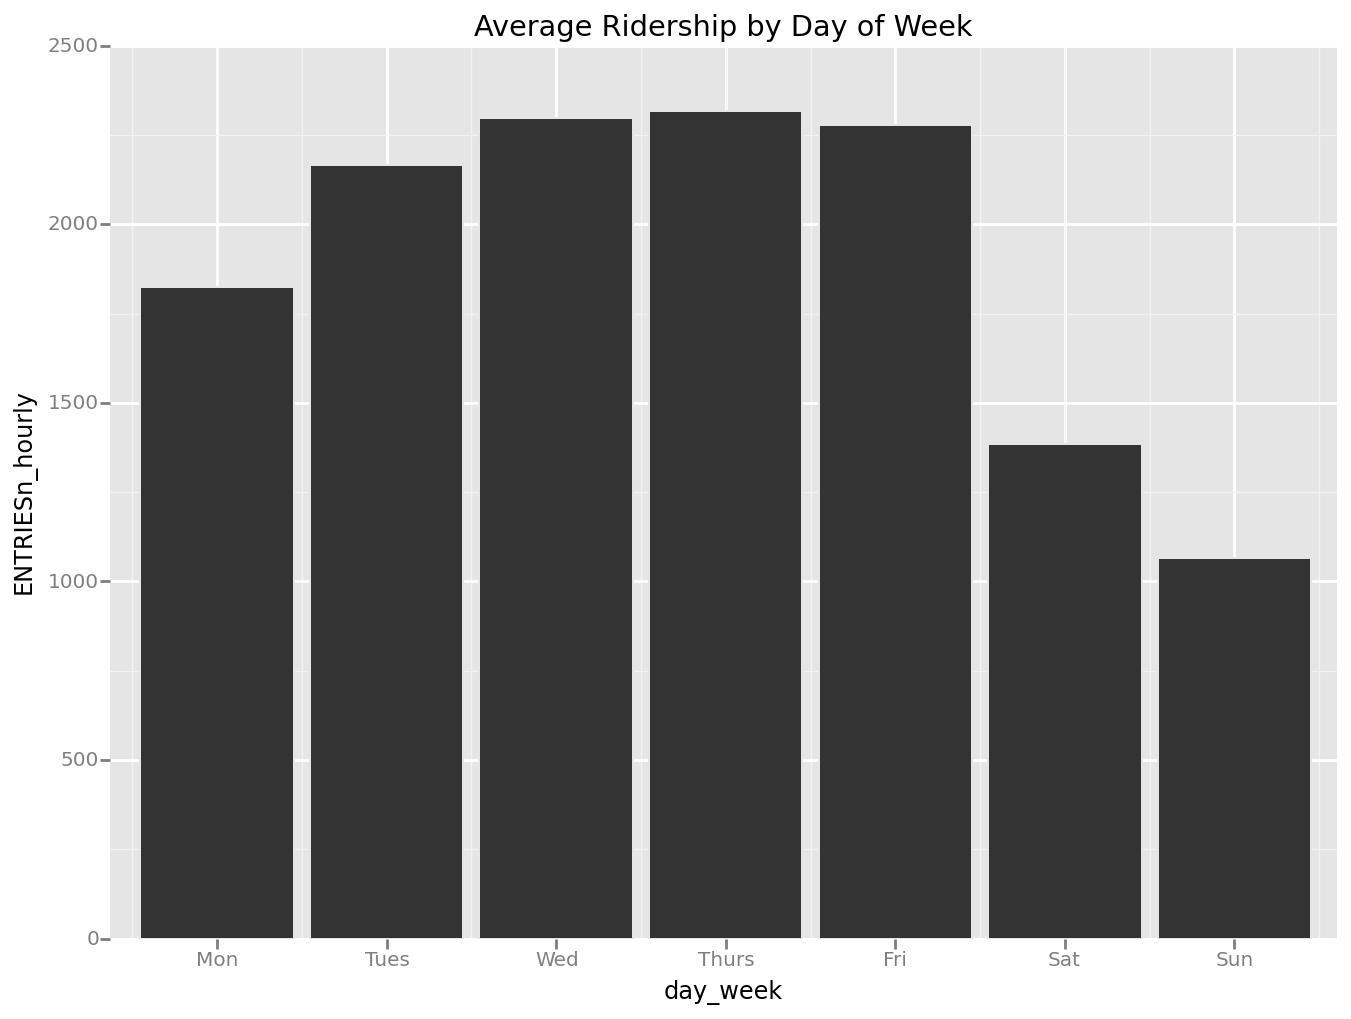

<ggplot: (314413461)>

In [449]:

def convertDays(x):
    if x == 0:
        return "Mon"
    elif x == 1:
        return "Tues"
    elif x == 2:
        return "Wed"
    elif x == 3:
        return "Thurs"
    elif x == 4:
        return "Fri"
    elif x == 5:
        return "Sat"
    elif x == 6:
        return "Sun"


grouped = df[["day_week","ENTRIESn_hourly"]].groupby("day_week")
ridership_day = grouped.aggregate(np.mean)
ridership_day = ridership_day.reset_index()

ridership_day["day_week"] = ridership_day["day_week"].map(convertDays)

gp.ggplot(ridership_day, gp.aes(x="day_week", y="ENTRIESn_hourly")) +\
    gp.geom_bar(stat='identity') +\
    gp.ggtitle('Average Ridership by Day of Week')

## Section 4. Conclusion
Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  

Yes, I believe taht more people ride the NYC subway when it is raining.

### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.
The Mann-Whitney U test performed on the two datasets, ridership with rain and ridership without rain, showed that the datasets did not come from the same distribution. Along with a higher mean of ridership while it was raining, it can be concluded that people do ride the NYC subway more.

In addition to the Mann-Whitney U test, a linear regression was performed to see what other factors play a role on NYC ridership. With the coefficients calculated we can compare the coefficients related to non-rainy days and rainy days. As suspected the coefficient for the cond_Rain feature was much larger than cond_Clear feature.

## Section 5. Reflection
Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

## 5.1 Please discuss potential shortcomings of the methods of your analysis, including:
The dataset provided does not account for how much of a factor holidays and special events play in subway ridership. These should either be included as dummy variables or be taken out to take account of outliers.

### 5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

From making the 'conds' column into a dummy variable, further insight can be seen in how more descriptive weather conditions play a role in subway ridership. By looking at the fog and mist condition's coefficient, it seems like they play a bigger role than rain in subway ridership.

In [5]:
def css_styling():
    styles = open("../css/custom.css", "r").read()
    return disp.HTML(styles)
css_styling()